# Images Folder

Your images folder should be at the same level of the RETFoud_MAE cloned folder. 

```
images/
RETFound_MAE/
    └── copy_images.ipynb
```

# Binary copy with (e.g : Messidor-2)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, io, random, math, glob, shutil

from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from pathlib import Path
from PIL import Image, ImageEnhance, ImageFilter, ImageOps, ImageDraw, ImageChops

In [3]:
# CSV
df = pd.read_csv("../images/messidor_2/messidor_data.csv")

# Binary classification
df['binary_DR'] = df['diagnosis'].apply(lambda x: 0 if x in [0, 1] else 1)

# Check
df[['id_code', 'diagnosis', 'binary_DR']].head()

,id_code,diagnosis,binary_DR
0,20051020_43808_0100_PP.png,0,0
1,20051020_43832_0100_PP.png,1,0
2,20051020_43882_0100_PP.png,1,0
3,20051020_43906_0100_PP.png,2,1
4,20051020_44261_0100_PP.png,0,0


Total images : 1744

Binary Classes distribution (0 = No/Low DR, 1 = mild to severe DR) :
  • Classe 0: 1287 images (73.8 %)
  • Classe 1: 457 images (26.2 %)


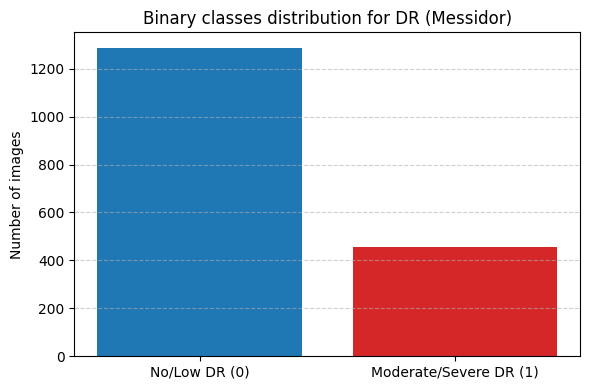

In [4]:
# Stats
distribution = df['binary_DR'].value_counts().sort_index()
total        = len(df)

# Text
print(f"Total images : {total}\n")
print("Binary Classes distribution (0 = No/Low DR, 1 = mild to severe DR) :")
for label, count in distribution.items():
    pct = 100 * count / total
    print(f"  • Classe {label}: {count} images ({pct:.1f} %)")

# Graph
labels = ['No/Low DR (0)', 'Moderate/Severe DR (1)']
counts = distribution.values
percents = 100 * counts / total

plt.figure(figsize=(6,4))
bars = plt.bar(labels, counts, color=['tab:blue', 'tab:red'])

plt.title("Binary classes distribution for DR (Messidor)")
plt.ylabel("Number of images")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

We have imbalanced distribution between class 1 and 0. We may want to try to use over-sampling on class 1 just as we did for the Lamphun dataset before

In [5]:
# Paths
BASE_DIR   = Path("../images/messidor_2")
CSV_PATH   = BASE_DIR / "messidor_data.csv"
DST_ROOT   = Path("data") # RETFound images folder

# Load and binary
df = pd.read_csv(CSV_PATH)
df["binary_DR"] = df["diagnosis"].apply(lambda x: 0 if x in [0, 1] else 1)

# Absolute path if images
df["filepath"] = df["id_code"].apply(lambda f: str(BASE_DIR / f))

In [6]:
SPLIT = {"train": 0.7, "val": 0.2, "test": 0.1}

# Split test (10%) from the full dataset
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=SPLIT["test"], random_state=974)
trainval_idx, test_idx = next(sss1.split(df, df["binary_DR"]))
df_trainval = df.iloc[trainval_idx].reset_index(drop=True)
df_test     = df.iloc[test_idx].reset_index(drop=True)

# Split val (20%) and train (70%) from the trainval
val_ratio = SPLIT["val"] / (SPLIT["train"] + SPLIT["val"])  # = 0.2 / 0.9 ≈ 0.222
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=974)
train_idx, val_idx = next(sss2.split(df_trainval, df_trainval["binary_DR"]))
df_train = df_trainval.iloc[train_idx].reset_index(drop=True)
df_val   = df_trainval.iloc[val_idx].reset_index(drop=True)

# Oversamplimpg the minority class (on training set only)
ros = RandomOverSampler(random_state=974)
X_over, y_over = ros.fit_resample(df_train[["filepath"]], df_train["binary_DR"])
df_train_balanced = df_train.set_index("filepath").loc[X_over["filepath"]].reset_index()
df_train_balanced["binary_DR"] = y_over

In [7]:
print("Train:")
print(df_train_balanced["binary_DR"].value_counts())
print("\nVal:")
print(df_val["binary_DR"].value_counts())
print("\nTest:")
print(df_test["binary_DR"].value_counts())

Train:
binary_DR
0    900
1    900
Name: count, dtype: int64

Val:
binary_DR
0    258
1     91
Name: count, dtype: int64

Test:
binary_DR
0    129
1     46
Name: count, dtype: int64


In [8]:
# Create folder for RETFound classes
for split_name in ["train", "val", "test"]:
    for class_value in [0, 1]:
        class_name = f"{class_value}" if class_value == 0 else f"{class_value}"
        target_dir = os.path.join("./data", split_name, class_name)
        os.makedirs(target_dir, exist_ok=True)

In [9]:
import shutil
from tqdm import tqdm

# New name column for oversampled data
df_train_balanced = df_train_balanced.reset_index(drop=True)
df_train_balanced["new_filename"] = df_train_balanced.index.astype(str) + "_" + df_train_balanced["id_code"]
df_val["new_filename"] = df_val["id_code"]
df_test["new_filename"] = df_test["id_code"]

# Regroup splits
splits = {
    "train": df_train_balanced,
    "val": df_val,
    "test": df_test
}

# Folder per split per class
base_dir = Path("data")
for split_name, df_split in splits.items():
    for class_value in [0, 1]:
        class_name = f"{class_value}" if class_value == 0 else f"{class_value}"
        target_dir = base_dir / split_name / class_name
        target_dir.mkdir(parents=True, exist_ok=True)

# Copy images
for split_name, df_split in splits.items():
    for idx, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Copying {split_name}"):
        class_value = row["binary_DR"]
        class_name = f"{class_value}" if class_value == 0 else f"{class_value}"

        src = Path(row["filepath"])
        dst_filename = row["new_filename"] + src.suffix
        dst = base_dir / split_name / class_name / dst_filename

        if src.exists():
            shutil.copy2(src, dst)
        else:
            print(f"[WARNING] File not found: {src}")

Copying test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 1039.82it/s]


In [10]:
# Path
ROOT = "./data"

# Classes and extension
CLASSES = ["1", "0"]
EXTS = (".jpg", ".jpeg", ".png")

# Collect and count
rows = []
for split in ["train", "val", "test"]:
    split_dir = os.path.join(ROOT, split)
    if not os.path.isdir(split_dir):
        print(f"no folders : {split_dir}")
        continue
        
    total_split = 0
    counts = {}
    for cls in CLASSES:
        pattern = os.path.join(split_dir, cls, "**", "*")
        n_imgs = sum(1 for f in glob.iglob(pattern, recursive=True)
                     if f.lower().endswith(EXTS) and os.path.isfile(f))
        counts[cls] = n_imgs
        total_split += n_imgs

    rows.append({
        "split": split,
        "n_total": total_split,
        **{f"n_{cls}": counts[cls] for cls in CLASSES},
        **{f"%_{cls}": counts[cls] * 100 / total_split if total_split else 0 for cls in CLASSES},
    })

df_counts = pd.DataFrame(rows)
df_counts.set_index("split", inplace=True)
df_counts = df_counts[["n_total"] +
                      [f"n_{c}" for c in CLASSES] +
                      [f"%_{c}" for c in CLASSES]]

display(df_counts.style.format(precision=2))

,n_total,n_1,n_0,%_1,%_0
split,,,,,
train,1800,900,900,50.00,50.00
val,349,91,258,26.07,73.93
test,175,46,129,26.29,73.71


# Multi-class copy (e.g Messidor-2)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, io, random, math, glob, shutil, re

from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from pathlib import Path
from PIL import Image, ImageEnhance, ImageFilter, ImageOps, ImageDraw, ImageChops
from collections import Counter

In [22]:
# CSV
df = pd.read_csv("../images/messidor_2/messidor_data.csv")

df

,id_code,diagnosis,adjudicated_dme,adjudicated_gradable
0,20051020_43808_0100_PP.png,0,0,1
1,20051020_43832_0100_PP.png,1,0,1
2,20051020_43882_0100_PP.png,1,0,1
3,20051020_43906_0100_PP.png,2,1,1
4,20051020_44261_0100_PP.png,0,0,1
...,...,...,...,...
1739,IM004806.JPG,0,0,1
1740,IM004811.JPG,1,0,1
1741,IM004812.JPG,2,0,1
1742,IM004831.JPG,0,0,1


Distribution :
diagnosis
0    1017
1     270
2     347
3      75
4      35
Name: count, dtype: int64


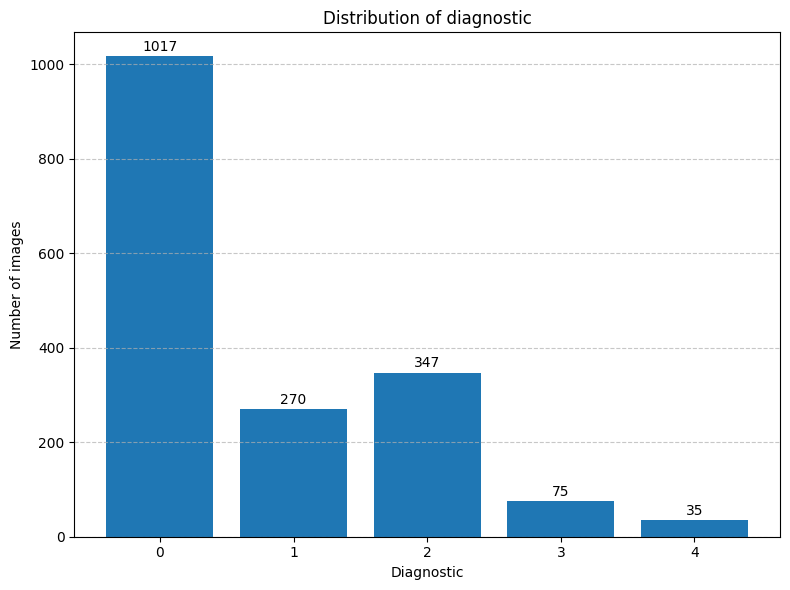

In [23]:
diagnosis_counts = df['diagnosis'].value_counts().sort_index()

# Print
print("Distribution :")
print(diagnosis_counts)

# Graph
plt.figure(figsize=(8, 6))
bars = plt.bar(diagnosis_counts.index.astype(str), diagnosis_counts.values)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, int(yval), ha='center', va='bottom')

plt.title("Distribution of diagnostic")
plt.xlabel("Diagnostic")
plt.ylabel("Number of images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Ajout d'images de classe 1 à 4 de Kaggle

In [19]:
# Config
csv_path   = "../images/kaggle/trainLabels.csv"
train_dir  = "/home/title/fundus_img/Kaggles/train"
test_dir   = "/home/title/fundus_img/Kaggles/test"
output_dir = "../images/kaggle"

# possible ext
exts = [".jpeg", ".jpg", ".png", ".bmp", ".tif", ".tiff", ".webp"]

# Create folder if not present
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Load and filtering on class 3 and 4
df = pd.read_csv(csv_path)
if not {"image", "level"}.issubset(df.columns):
    raise ValueError("CSV must contain columns image and level")

df_filtered = df[df["level"].isin([1, 2, 3, 4])].copy()
print(f"Image to search : {len(df_filtered)}")

# utils
def find_image_path(stem: str) -> Path | None:
    for base_dir in (train_dir, test_dir):
        for ext in exts:
            p = Path(base_dir) / f"{stem}{ext}"
            if p.exists():
                return p
            # upper-case just in case
            p2 = Path(base_dir) / f"{stem}{ext.upper()}"
            if p2.exists():
                return p2
    return None

# Copy
copied, skipped, missing = 0, 0, []
count_classes = {1: 0, 2: 0, 3: 0, 4: 0}

for _, row in df_filtered.iterrows():
    stem  = str(row["image"]).strip()
    level = int(row["level"])

    src = find_image_path(stem)
    if src is None:
        missing.append(stem)
        continue

    dest_name = f"{stem}_lvl{level}{src.suffix.lower()}"
    dest = Path(output_dir) / dest_name

    if dest.exists():
        skipped += 1
        continue

    shutil.copy2(src, dest)
    copied += 1
    count_classes[level] += 1

# Summary
print(f"Copied : {copied} | Ignored (already exist) : {skipped} | Not found : {len(missing)}")
for lvl in range(1, 5):
    print(f"Class {lvl} copied : {count_classes[lvl]}")

Image to search : 9316
Copied : 9316 | Ignored (already exist) : 0 | Not found : 0
Class 1 copied : 2443
Class 2 copied : 5292
Class 3 copied : 873
Class 4 copied : 708


### New distribution

Looking at the distribution from Kaggle, we should then use the lowest class count (from class 4) as our target number to reach from each class in our final dataset. We are going to add images to each class from our Messidor distribution in order to obtain 743 images per class. This come from the addition of Messidor class 4 count and Kaggle's dataset class 4 count (708+35 = 743)

Distribution Messidor :
diagnosis
0    1017
1     270
2     347
3      75
4      35
Name: count, dtype: int64

Kaggle disponible (1–4) :
0       0
1    2443
2    5292
3     873
4     708
dtype: int64

Target possible for a balanced distribution (classes 1–4) : 743

Kaggle used to reach target :
0      0
1    473
2    396
3    668
4    708
dtype: int64

Kaggle not used :
0       0
1    1970
2    4896
3     205
4       0
dtype: int64

New toal :
diagnosis
0    1017
1     743
2     743
3     743
4     743
dtype: int64


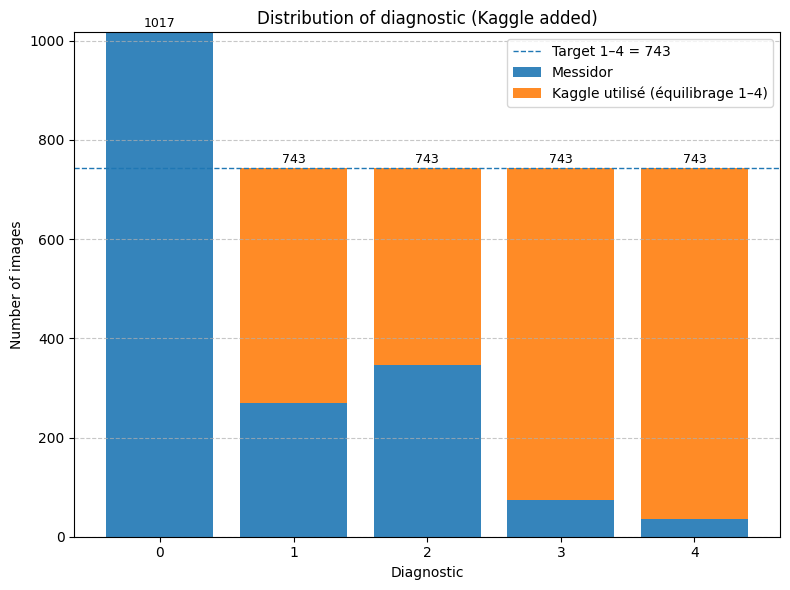

In [24]:
messidor_counts = df['diagnosis'].value_counts().sort_index()
messidor_counts = messidor_counts.reindex(range(5), fill_value=0)

# Count Kaggle (../images/kaggle/name*_lvl{1..4}.*)
kaggle_dir = "../images/kaggle"
kaggle_counts = Counter({0:0, 1:0, 2:0, 3:0, 4:0})

if os.path.isdir(kaggle_dir):
    pattern = re.compile(r"_lvl([1-4])\.[^.]+$", re.IGNORECASE)
    for fname in os.listdir(kaggle_dir):
        m = pattern.search(fname)
        if m:
            lvl = int(m.group(1))
            kaggle_counts[lvl] += 1
else:
    print(f"Folder not found : {kaggle_dir}.")

kaggle_avail = pd.Series([kaggle_counts[i] for i in range(5)], index=range(5))

# Balance the number of class (0 ignored) based on the lowest count class (class 4)
target_1_4 = min(messidor_counts[c] + kaggle_avail[c] for c in [1,2,3,4])

# Usable Kaggle image 
kaggle_used_vals = []
for c in range(5):
    if c == 0:
        kaggle_used_vals.append(0)
    else:
        need = max(0, target_1_4 - messidor_counts[c])
        use  = min(kaggle_avail[c], need)
        kaggle_used_vals.append(int(use))

kaggle_used = pd.Series(kaggle_used_vals, index=range(5))
kaggle_left = kaggle_avail - kaggle_used

# New count
total_after = messidor_counts + kaggle_used

# --- Prints ---
print("Distribution Messidor :")
print(messidor_counts)
print("\nKaggle disponible (1–4) :")
print(kaggle_avail)
print(f"\nTarget possible for a balanced distribution (classes 1–4) : {target_1_4}")
print("\nKaggle used to reach target :")
print(kaggle_used)
print("\nKaggle not used :")
print(kaggle_left)
print("\nNew toal :")
print(total_after)

# Graph
plt.figure(figsize=(8, 6))
x = np.arange(5).astype(str)  # "0","1","2","3","4"

bars_base = plt.bar(x, messidor_counts.values, label="Messidor", alpha=0.9)
bars_add  = plt.bar(x, kaggle_used.values, bottom=messidor_counts.values,
                    label="Kaggle utilisé (équilibrage 1–4)", alpha=0.9)

# Horizontal line
plt.axhline(y=target_1_4, linestyle="--", linewidth=1, label=f"Target 1–4 = {target_1_4}")

# Labels over
for i, (b1, add_val) in enumerate(zip(bars_base, kaggle_used.values)):
    total_val = messidor_counts.values[i] + add_val
    plt.text(b1.get_x() + b1.get_width()/2, b1.get_height() + add_val + 5,
             int(total_val), ha='center', va='bottom', fontsize=9)

plt.title("Distribution of diagnostic (Kaggle added)")
plt.xlabel("Diagnostic")
plt.ylabel("Number of images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### Physical split and copy to the data folder

In [25]:
for split_name in ["train", "val", "test"]:
    for class_value in range(5):  # classes 0 à 4
        class_name = str(class_value)
        target_dir = os.path.join("./data", split_name, class_name)
        os.makedirs(target_dir, exist_ok=True)

In [29]:
# CONFIG

# Paths
messidor_dir = "../images/messidor_2"      
kaggle_dir   = "../images/kaggle"         
output_root  = "./data"                   # final split root: ./data/{train,val,test}/{0..4}/

# File extensions
exts = [".jpeg", ".jpg", ".png"]

# Reproducibility
RANDOM_SEED = 974
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# HELPERS
def find_path_in_dir(stem: str, base_dir: str) -> Path:
    """
    Resolve an image path given its stem (without extension) by trying known extensions
    in lower and upper case, inside 'base_dir'. Returns Path or None.
    """
    stem = str(stem).strip()
    for e in exts:
        p = Path(base_dir) / f"{stem}{e}"
        if p.exists():
            return p
        p2 = Path(base_dir) / f"{stem}{e.upper()}"
        if p2.exists():
            return p2
    return None

In [30]:
required_cols = {"id_code", "diagnosis"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"Messidor df must contain columns: {required_cols}")

df = pd.read_csv("../images/messidor_2/messidor_data.csv")
df_messidor = df.copy()

# Build absolute/relative file paths by joining the folder with id_code
df_messidor["filepath"] = df_messidor["id_code"].apply(lambda s: str(Path(messidor_dir) / str(s)))

# Keep only valid classes and existing files
df_messidor = df_messidor[df_messidor["diagnosis"].isin([0,1,2,3,4])].copy()
df_messidor["exists"] = df_messidor["filepath"].apply(lambda p: Path(p).exists())

missing_messidor = df_messidor.loc[~df_messidor["exists"]]
if len(missing_messidor) > 0:
    print(f"{len(missing_messidor)} Messidor images not found; they will be dropped.")

df_messidor = df_messidor.loc[df_messidor["exists"]].drop(columns=["exists"])

# Base distribution (Messidor only)
messidor_counts = df_messidor["diagnosis"].value_counts().sort_index().reindex(range(5), fill_value=0)
print("Messidor counts:", dict(messidor_counts))

Messidor counts: {0: 1017, 1: 270, 2: 347, 3: 75, 4: 35}


In [31]:
# Scan Kaggle directory: filenames must contain *_lvl{1..4}.*
if not os.path.isdir(kaggle_dir):
    raise FileNotFoundError(f"Kaggle folder not found: {kaggle_dir}")

pat = re.compile(r"_lvl([1-4])\.[^.]+$", re.IGNORECASE)
k_by_class = {1: [], 2: [], 3: [], 4: []}
for fname in os.listdir(kaggle_dir):
    m = pat.search(fname)
    if m:
        lvl = int(m.group(1))
        k_by_class[lvl].append(str(Path(kaggle_dir) / fname))

k_avail = {c: len(k_by_class[c]) for c in [1,2,3,4]}
print("Kaggle available (1–4):", k_avail)

# Balanced target reachable on classes 1–4 (class 0 is ignored)
target_1_4 = min(messidor_counts[c] + k_avail[c] for c in [1,2,3,4])

# Number of Kaggle images to add per class to hit the target
to_copy = {c: max(0, min(k_avail[c], target_1_4 - messidor_counts[c])) for c in [1,2,3,4]}

print("Target per class (1–4) =", target_1_4)
print("To copy per class:", to_copy)

# Select the exact files (random, reproducible)
selected_k_paths, selected_k_labels = [], []
for c in [1,2,3,4]:
    need = to_copy[c]
    if need <= 0:
        continue
    cand = k_by_class[c]
    if len(cand) <= need:
        chosen = cand
    else:
        chosen = random.sample(cand, k=need)
    selected_k_paths.extend(chosen)
    selected_k_labels.extend([c] * len(chosen))

df_kaggle_sel = pd.DataFrame({
    'filepath': selected_k_paths,
    'diagnosis': selected_k_labels
})

print(f"Kaggle selected: {len(df_kaggle_sel)} images")
print("Selected per class:", dict(df_kaggle_sel['diagnosis'].value_counts().sort_index()))

Kaggle available (1–4): {1: 2443, 2: 5292, 3: 873, 4: 708}
Target per class (1–4) = 743
To copy per class: {1: 473, 2: 396, 3: 668, 4: 708}
Kaggle selected: 2245 images
Selected per class: {1: 473, 2: 396, 3: 668, 4: 708}


In [32]:
# Merge Messidor + selected Kaggle
df_all = pd.concat(
    [df_messidor[['filepath', 'diagnosis']], df_kaggle_sel[['filepath', 'diagnosis']]],
    ignore_index=True
)

# Sanity check
final_counts = df_all['diagnosis'].value_counts().sort_index().reindex(range(5), fill_value=0)
print("Final counts before split:", dict(final_counts))

# Stratified split 70/20/10
train_df, temp_df = train_test_split(
    df_all, test_size=0.3, stratify=df_all['diagnosis'], random_state=RANDOM_SEED
)
val_df, test_df = train_test_split(
    temp_df, test_size=1/3, stratify=temp_df['diagnosis'], random_state=RANDOM_SEED
)

print("Split sizes:", len(train_df), len(val_df), len(test_df))
print("Train dist:", dict(train_df['diagnosis'].value_counts().sort_index()))
print("Val   dist:", dict(val_df['diagnosis'].value_counts().sort_index()))
print("Test  dist:", dict(test_df['diagnosis'].value_counts().sort_index()))

Final counts before split: {0: 1017, 1: 743, 2: 743, 3: 743, 4: 743}
Split sizes: 2792 798 399
Train dist: {0: 712, 1: 520, 2: 520, 3: 520, 4: 520}
Val   dist: {0: 203, 1: 148, 2: 149, 3: 149, 4: 149}
Test  dist: {0: 102, 1: 75, 2: 74, 3: 74, 4: 74}


In [33]:
# Create split folders
for split_name in ["train", "val", "test"]:
    for class_value in range(5):
        target_dir = Path(output_root) / split_name / str(class_value)
        target_dir.mkdir(parents=True, exist_ok=True)

def copy_split(df_split, split_name: str):
    copied, missing, skipped = 0, 0, 0
    for _, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Copying {split_name}"):
        src = Path(row['filepath'])
        cls = int(row['diagnosis'])
        dst = Path(output_root) / split_name / str(cls) / src.name

        if not src.exists():
            missing += 1
            continue

        if dst.exists():
            # Don't overwrite (keeps idempotency)
            skipped += 1
            continue

        shutil.copy2(src, dst)
        copied += 1

    print(f"{split_name}: copied={copied}, skipped={skipped}, missing={missing}")

# Execute copies
copy_split(train_df, "train")
copy_split(val_df,   "val")
copy_split(test_df,  "test")

print("Done. Files are under ./data/{train,val,test}/{0..4}/")

Copying train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2792/2792 [00:02<00:00, 1382.33it/s]


train: copied=2792, skipped=0, missing=0


Copying val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 798/798 [00:00<00:00, 1279.17it/s]


val: copied=798, skipped=0, missing=0


Copying test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1388.65it/s]

test: copied=399, skipped=0, missing=0
Done. Files are under ./data/{train,val,test}/{0..4}/


# Unlabelled data copy for inference

The following code is used to copy unlabelled data into RETFound_MAE/data/test/dummy to make prediction by a fine-tuned model.

In [11]:
import os
import shutil
from tqdm import tqdm

# Source folder with unlabelled images
src_dir = "../images/chula/10k_images"

# Create folders for RETFound classes
splits = ["train", "val", "test"]
for split_name in splits:
    target_dir = os.path.join("./data", split_name, "dummy")
    os.makedirs(target_dir, exist_ok=True)

# Destination for bulk copy
test_dst_dir = "./data/test/dummy"

# List all image files
image_files = sorted([
    f for f in os.listdir(src_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

print(f"Number of images found : {len(image_files)}")

# Copy ALL images to test/dummy
for filename in tqdm(image_files, desc="Copy to test"):
    src_path = os.path.join(src_dir, filename)
    dst_path = os.path.join(test_dst_dir, filename)
    shutil.copy2(src_path, dst_path)

# Copy one image to train/dummy and another to val/dummy
if len(image_files) >= 2:
    shutil.copy2(os.path.join(src_dir, image_files[0]),
                 os.path.join("./data/train/dummy", image_files[0]))
    
    shutil.copy2(os.path.join(src_dir, image_files[1]),
                 os.path.join("./data/val/dummy", image_files[1]))
    print("1 image copied to train/dummy and 1 to val/dummy.")
else:
    print("Not enough images to copy to train and val.")

print("Done.")

Number of images found : 10000


Copy to test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 234.61it/s]

1 image copied to train/dummy and 1 to val/dummy.
Done.
